# Segmentation model to extract features from a C. elegans embryo

## Step 1: Importing all the utils 
* We'll be using [PyTorch](https://pytorch.org/) for training and deploying the models. 
* [albumentations](https://github.com/albumentations-team/albumentations) is used for building the image augmentation pipeline
* [segmentation-models-pytorch](https://github.com/qubvel/segmentation_models.pytorch) is a Python library to build Neural Networks for Image
Segmentation based on PyTorch

In [ ]:
# Install required libs
!pip install albumentations  
!pip install segmentation-models-pytorch

In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage

import segmentation_models_pytorch as smp
from albumentations import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Step 2: Loading up the data 
* The tarball containing the images and the masks can be found [here](https://github.com/devoworm/GSoC-2020/blob/master/Pre-trained%20Models%20(DevLearning)/notebooks/embryo_segmentation/data/image_data.tar.xz)

In [ ]:
!cp /content/drive/"My Drive"/segmentation/image_data.tar.xz /content/
!tar -xf /content/image_data.tar.xz -C /content/

### Custom class for a segmentation dataset 

The class has 4 key parts
* `self.image_paths` is a list of all the images within `image_folder_name` sorted in order 
* `self.mask_paths` is the same as `self.image_paths` but contains the sorted list of the filenames of the mask images in `mask_folder_name`
*  `self.transform` contains the list of [torchvision.transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) to be applied on the image and the mask before returning 
* `self.augmentation` contains the common set of augmentations for the image and the mask, we had to make sure for the fact that both the image and the mask go through the exact same set of augmentative transforms 

`mask[mask != 0] = 255` converts all the non zero values within the mask to 255, this was done because `transforms.ToTensor()` the converts the range `[0,255]` to `[0.,1.]`


In [ ]:
class SegmentationDataset(Dataset):   
    def __init__(self, image_folder_name, mask_folder_name, augmentation =None, transform = None):
        
        self.image_paths  = np.array(np.sort([image_folder_name + "/" + i for i in os.listdir(image_folder_name)]))
        self.mask_paths  = np.array(np.sort([mask_folder_name + "/"+ i for i in os.listdir(mask_folder_name)]))
        self.transform = transform
        self.augmentation = augmentation


    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], 0)
        mask = cv2.imread(self.mask_paths[idx], 0)

        if self.augmentation is not None:
                
            augmented  = self.augmentation(image = image, mask = mask)
            image = augmented["image"]
            mask = augmented["mask"]

        mask[mask != 0] = 255
    
        return self.transform(image), self.transform(mask)
    
    def __len__(self):
        return len(self.image_paths)
        

train_dataset = SegmentationDataset("images", 
                                    "masks",
                                    augmentation =  Compose([
                                                            GridDistortion(p=0.5),
                                                            Transpose(p=0.5),
                                                            VerticalFlip(p=0.5),
                                                            HorizontalFlip(p=0.5),
                                                            RandomRotate90(p=0.5),
                                                            RandomBrightnessContrast( p=0.5),
                                                            RandomSizedCrop(p=0.3, min_max_height=(350, 400), height=256, width=256)
                                                            ]),

                                    transform = transforms.Compose([ 
                                                                    
                                                                    transforms.ToPILImage(),
                                                                    transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                                    ToTensor()
                                                                ])
                                    )

In [ ]:
train_batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle = True)
print(len(train_loader))

36


### Visualising a single batch of the training data 

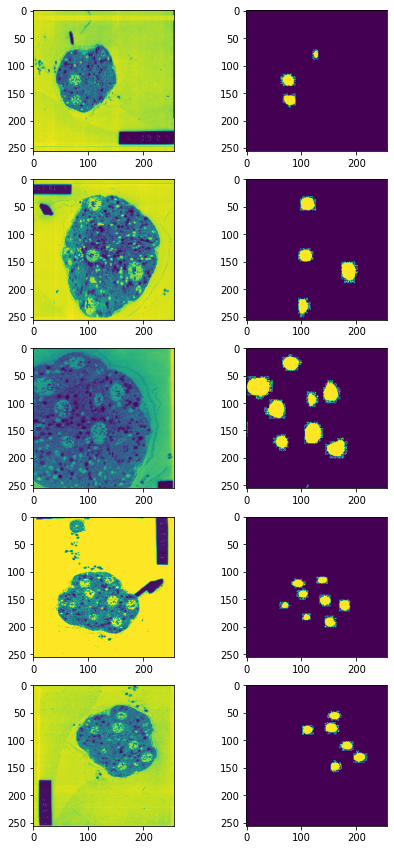

In [ ]:
batch  = next(iter(train_loader))

images, masks = batch
fig, ax = plt.subplots(train_batch_size, 2, figsize = (7,15))

for i in range(train_batch_size):

    ax[i][0].imshow(images[i][0])
    ax[i][1].imshow(masks[i][0])

In [ ]:
## workaround to fix model download 
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

 ## Step 3: Downloading the model weights 

 * For our case, we use the [pre-trained ResNet18](https://supervise.ly/explore/models/res-net-18-image-net-2717/overview) as the encoder. 
 * `ACTIVATION = 'sigmoid'` clamps the output pixel values between `[0.,1.]`, which are ideal for calculating a loss with respect to a mask whose pixel values also are within the same range. 
 * `DEVICE = 'cuda'` moves the model to the GPU for faster training.
 * `in_channels = 1` means the model you take grayscale images as input, set it to 3 for RGB images.

In [ ]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ["nucleus"]
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
in_channels = 1

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    in_channels = in_channels 
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

## The loss function 

The [**Intersection Over Union**](https://en.wikipedia.org/wiki/IOU) score (also known as Jaccard Index) is a statistic used for gauging the similarity and diversity of sample sets. It is defined as:

$$ J(A,B) = {{|A \cap B|}\over{|A \cup B|}} = {{|A \cap B|}\over{|A| + |B| - |A \cap B|}} $$

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png"  height = "200" width = "250" align="center"/>


 [**Dice Coefficient**](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) can be seen as the percentage of overlap between the two sets, that is a number between 0 and 1. `DiceLoss()` can be mathematically defined as  $ 1 - Dice coefficient $:

$$ Dice loss = 1- \frac{2\left | X \cap Y  \right |}{\left | X \right | + \left | Y \right |} $$


where $ |X| ∩ |Y| $ is the intersection where the prediction correctly overlaps the label in the 2D mask. 


In [ ]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00015),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=False,
)


In [ ]:
max_score = 0
dice_losses = []
iou_scores  = []
times = []

## The training loop

The best model is determined with respect to it's IOU score and is saved.

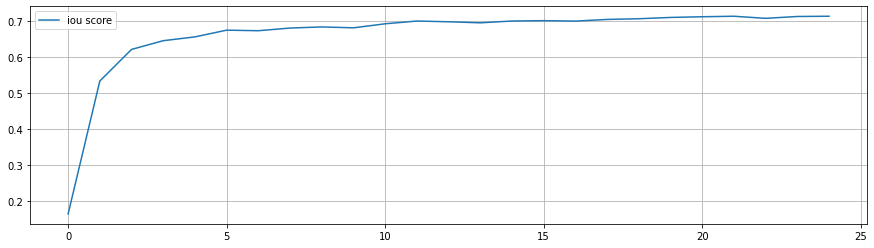

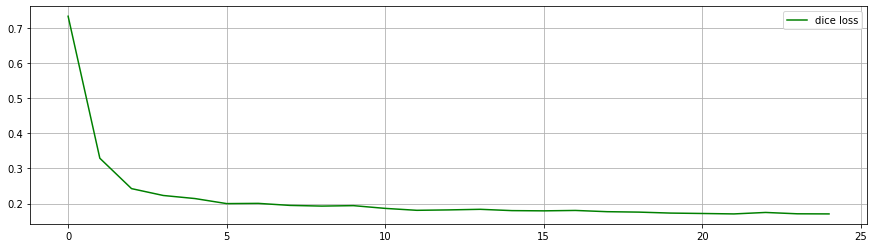

In [ ]:
epochs = 25
plt.rcParams['figure.figsize'] = 15, 4
start_time = time.process_time()

for i in range(0, epochs):

    print('\nEpoch: {}'.format(i))

    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(train_loader)

    dice_losses.append(train_logs["dice_loss"]) 
    times.append(time.process_time() - start_time)
    iou_scores.append(train_logs["iou_score"])

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    clear_output(wait = True)
    
    plt.plot(iou_scores, label = "iou score")
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(dice_losses, color = "green", label = "dice loss")
    plt.legend()
    plt.grid()
    plt.show()

## Visualizing the model outputs 

For a smoother and more consistent output, all output pixel values above 0.1 are set to 1, as seen in `show_pred[show_pred > 0.1] = 1`

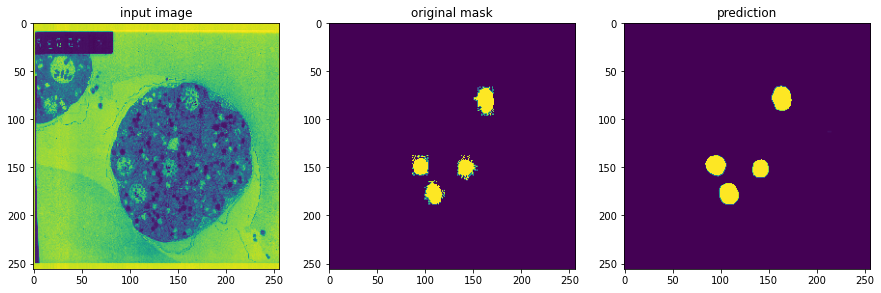

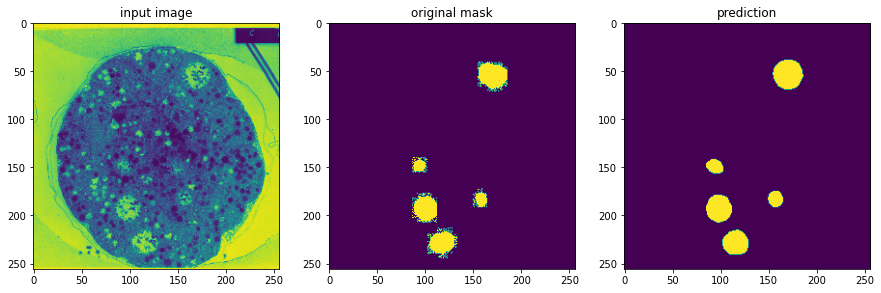

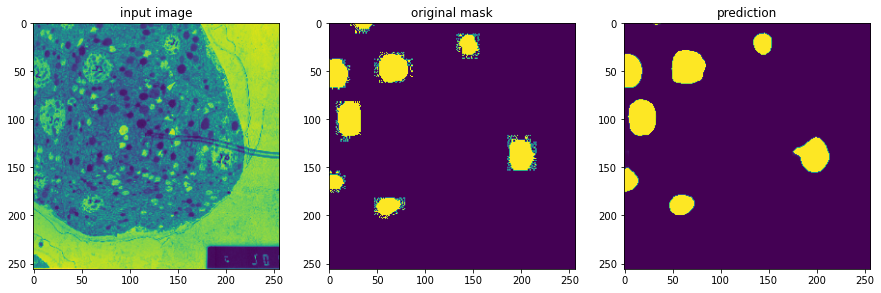

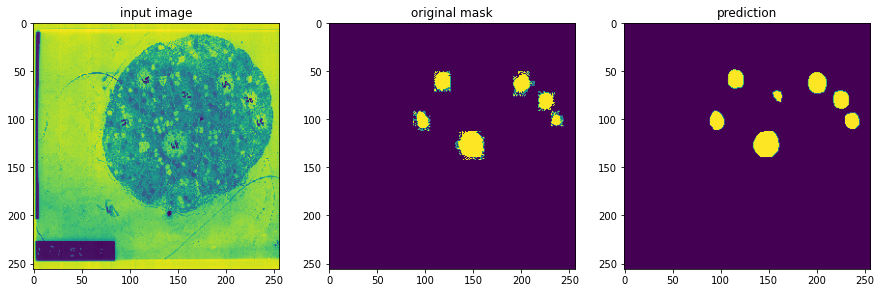

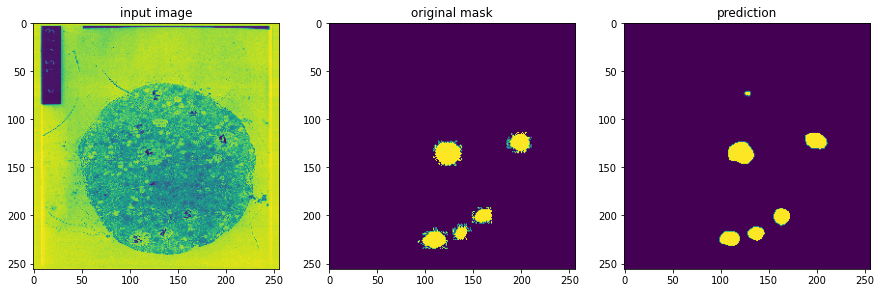

In [ ]:
image, masks = next(iter(train_loader))

for i in range(len(image)):
    inp = image[i].cuda().unsqueeze(0)
    pred = model(inp).squeeze(0).squeeze(0).detach().cpu()
    show_img = inp.cpu()[0][0]
    show_pred = model(inp).squeeze(0).squeeze(0).detach().cpu()
    show_pred[show_pred > 0.1] = 1
    show_mask = masks[i][0].cpu()
    fig, ax = plt.subplots(1,3, figsize = (15,35))

    ax.flat[0].imshow(show_img)
    ax.flat[0].title.set_text('input image')

    
    ax.flat[1].imshow(show_mask)
    ax.flat[1].title.set_text('original mask')

    ax.flat[2].imshow(show_pred)
    ax.flat[2].title.set_text('prediction')



In [ ]:
torch.save(model.state_dict(), "model.pt")